<a href="https://colab.research.google.com/github/paulmyr/jaxley/blob/main/notebooks/jaxley_test_adex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use custom jaxley build<br>
-> fork in github.com/paulmyr/jaxley.git

In [56]:
!git clone https://github.com/paulmyr/jaxley.git
!pip install tridiax
!pip install brian2

import jax
import jax.numpy as jnp
from jax import grad, value_and_grad
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '/content/jaxley')

import jaxley as jx
from jaxley.channels import AdEx


fatal: destination path 'jaxley' already exists and is not an empty directory.


Parameters from the paper:

In [57]:

NAUD_PARAMETERS = {
    'tonic': {
        'C_m': 200,      # pF - Membrane capacitance
        'g_L': 10,       # nS - Leak conductance
        'E_L': -70,      # mV - Leak reversal potential
        'v_T': -50,      # mV - Spike threshold
        'delta_T': 2,    # mV - Spike slope factor
        'v_reset': -58,  # mV - Reset potential (NOT -70!)
        'v_threshold': 0,  # mV - Detection threshold for spike cutoff
        'tau_w': 30,     # ms - Adaptation time constant
        'a': 2,          # nS - Subthreshold adaptation
        'b': 0,          # pA - Spike-triggered adaptation (none for tonic)
        'I': 500,        # pA - Injected Current
    },
    'adaptation': {
        'C_m': 200,      # pF
        'g_L': 12,       # nS - Slightly higher leak
        'E_L': -70,      # mV
        'v_T': -50,      # mV
        'delta_T': 2,    # mV
        'v_reset': -58,  # mV
        'v_threshold': 0,  # mV
        'tau_w': 300,    # ms - 10x slower adaptation!
        'a': 2,          # nS
        'b': 60,         # pA - Strong spike-triggered adaptation
        'I': 500,        # pA - Injected Current
    },
    'original': {
        'C_m': 281,        # pF
        'g_L': 30,         # nS - Slightly higher leak
        'E_L': -70.6,      # mV
        'v_T': -50.4,      # mV
        'delta_T': 2,      # mV
        'v_reset': -70.6,  # mV
        'v_threshold': 20, # mV
        'tau_w': 144,      # ms - 10x slower adaptation!
        'a': 4,            # nS
        'b': 80.5,         # pA - Strong spike-triggered adaptation
        'I': 2500,         # pA - Injected Current
    },
}


parameters = NAUD_PARAMETERS['adaptation']

In [58]:
def plot_comparison(brian2_results, jaxley_results, params, title="AdEx Comparison"):
    """
    Plot side-by-side comparison of Brian2 and Jaxley results.

    Args:
        brian2_results: Tuple of (time, voltage, w, spike_times)
        jaxley_results: Tuple of (time, voltage, w)
        params: Parameter dictionary
        title: Plot title
    """
    t_brian, v_brian, w_brian, spikes_brian = brian2_results
    t_jaxley, v_jaxley, w_jaxley = jaxley_results

    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    fig.suptitle(title, fontsize=16)

    # Voltage traces
    axes[0, 0].plot(t_brian, v_brian, 'b-', linewidth=1.5, label='Brian2')
    axes[0, 0].axhline(params['v_threshold'], color='r', linestyle='--', alpha=0.5, label='Threshold')
    axes[0, 0].set_ylabel('Voltage (mV)')
    axes[0, 0].set_title('Brian2: Membrane Potential')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(t_jaxley, v_jaxley, 'g-', linewidth=1.5, label='Jaxley')
    axes[0, 1].axhline(params['v_threshold'], color='r', linestyle='--', alpha=0.5, label='Threshold')
    axes[0, 1].set_ylabel('Voltage (mV)')
    axes[0, 1].set_title('Jaxley: Membrane Potential')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Adaptation current
    if w_brian is not None:
        axes[1, 0].plot(t_brian, w_brian, 'b-', linewidth=1.5)
        axes[1, 0].set_ylabel('w (pA)')
        axes[1, 0].set_title('Brian2: Adaptation Current')
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'No data', ha='center', va='center', transform=axes[1, 0].transAxes)

    if w_jaxley is not None:
        axes[1, 1].plot(t_jaxley, w_jaxley, 'g-', linewidth=1.5)
        axes[1, 1].set_ylabel('w (pA)')
        axes[1, 1].set_title('Jaxley: Adaptation Current')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'Not recorded', ha='center', va='center', transform=axes[1, 1].transAxes)

    # Overlay comparison
    axes[2, 0].plot(t_brian, v_brian, 'b-', linewidth=1.5, label='Brian2', alpha=0.7)
    axes[2, 0].plot(t_jaxley, v_jaxley, 'g--', linewidth=1.5, label='Jaxley', alpha=0.7)
    axes[2, 0].axhline(params['v_threshold'], color='r', linestyle='--', alpha=0.5, label='Threshold')
    axes[2, 0].set_xlabel('Time (ms)')
    axes[2, 0].set_ylabel('Voltage (mV)')
    axes[2, 0].set_title('Overlay Comparison')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)

    # Spike raster / difference plot
    if len(spikes_brian) > 0:
        axes[2, 1].eventplot([spikes_brian], colors='b', lineoffsets=1, linelengths=0.8, label='Brian2 spikes')
        axes[2, 1].set_ylabel('Spikes')
        axes[2, 1].set_xlabel('Time (ms)')
        axes[2, 1].set_title('Brian2 Spike Times')
        axes[2, 1].set_ylim(0, 2)
        axes[2, 1].grid(True, alpha=0.3)
    else:
        axes[2, 1].text(0.5, 0.5, 'No spikes detected', ha='center', va='center', transform=axes[2, 1].transAxes)

    plt.tight_layout()
    return fig


In [59]:
from brian2 import *

def run_brian2_adex(params, I_ext, dt_ms=0.025, duration_ms=500.0):
    """
    Run AdEx simulation using Brian2.

    Args:
        params: Dictionary of AdEx parameters
        I_ext: External current (pA)
        dt_ms: Time step in milliseconds
        duration_ms: Simulation duration in milliseconds

    Returns:
        time_array, voltage_array, w_array (all in SI units converted to mV/ms/pA)
    """
    # Convert parameters to Brian2 units
    C_m = params['C_m'] * pF
    g_L = params['g_L'] * nS
    E_L = params['E_L'] * mV
    v_T = params['v_T'] * mV
    delta_T = params['delta_T'] * mV
    v_threshold = params['v_threshold'] * mV
    v_reset = params['v_reset'] * mV
    tau_w = params['tau_w'] * ms
    a = params['a'] * nS
    b = params['b'] * pA

    # External current
    I_input = I_ext * pA

    # AdEx equations (standard form from Brette & Gerstner 2005)
    eqs = '''
    dv/dt = (g_L*(E_L-v) + g_L*delta_T*exp((v-v_T)/delta_T) - w + I_input)/C_m : volt
    dw/dt = (a*(v-E_L) - w)/tau_w : amp
    '''

    # Create neuron
    defaultclock.dt = dt_ms * ms
    neuron = NeuronGroup(1, eqs, threshold='v>v_threshold', reset='v=v_reset; w+=b', method='euler')

    # Initial conditions
    neuron.v = params['v_reset'] * mV
    neuron.w = 0

    # Record variables
    mon_v = StateMonitor(neuron, 'v', record=True)
    mon_w = StateMonitor(neuron, 'w', record=True)
    spike_mon = SpikeMonitor(neuron)

    # Run simulation
    run(duration_ms * ms)

    # Extract results (convert back to standard units)
    time_array = mon_v.t / ms  # ms
    voltage_array = mon_v.v[0] / mV  # mV
    w_array = mon_w.w[0] / pA  # pA

    return time_array, voltage_array, w_array, spike_mon.t / ms

In [60]:
dt = 0.025
duration = 600
t_brian, v_brian, w_brian, spikes_brian = run_brian2_adex(
    parameters, parameters['I'], dt_ms=dt, duration_ms=duration
)

In [61]:
import numpy as np

def geometry_for_capacitance(C_pF, specific_capacitance=1.0):
    """Calculate cylindrical cell geometry to achieve target total capacitance."""
    C_uF = C_pF * 1e-6
    area_cm2 = C_uF / specific_capacitance
    radius_cm = np.sqrt(area_cm2 / (6.28 * np.pi))
    radius_um = radius_cm * 1e4
    length_um = 3.14 * radius_um
    return radius_um, length_um, area_cm2


def run_jaxley_adex(params, I_ext, dt_ms=0.025, duration_ms=500.0):
    """
    Run AdEx simulation using Jaxley.

    Args:
        params: Dictionary of AdEx parameters
        I_ext: External current (pA)
        dt_ms: Time step in milliseconds
        duration_ms: Simulation duration in milliseconds

    Returns:
        time_array, voltage_array, w_array
    """

    mode = 'tonic'

    radius_um, length_um, area_cm2 = geometry_for_capacitance(params['C_m'])

    # Create cell with proper geometry
    cell = jx.Cell()
    cell.set('radius', radius_um)
    cell.set('length', length_um)

    # Insert AdEx channel
    cell.insert(AdEx())

    # Set AdEx parameters (convert to density units)
    g_L_density = (params['g_L'] * 1e-9) / area_cm2  # nS -> S/cm^2
    a_density = (params['a'] * 1e-9) / area_cm2   # nS -> S/cm^2
    b_density = (params['b'] * 1e-9) / area_cm2  # pA -> mA/cm^2

    cell.set("capacitance", params['C_m'])  # μF/cm² (standard)
    cell.set("AdEx_g_L", params['g_L'])
    cell.set("AdEx_E_L", params['E_L'])
    cell.set("AdEx_v_T", params['v_T'])
    cell.set("AdEx_delta_T", params['delta_T'])
    cell.set("AdEx_v_threshold", params['v_threshold'])
    cell.set("AdEx_v_reset", params['v_reset'])
    cell.set("AdEx_tau_w", params['tau_w'])
    cell.set("AdEx_a", params['a'])
    cell.set("AdEx_b", params['b'])

    # Set initial conditions
    cell.set("v", params['v_reset'])

    cell.record("v")
    cell.record("AdEx_w")
    cell.record("AdEx_spikes")

    # Create current injection
    # jx.step_current expects nA, not density!


    I_nA = params['I'] / 1000.0  # pA -> nA

    # Inject current
    cell.stimulate(jx.step_current(0.0, duration_ms, I_nA, dt_ms, duration_ms))

    # Run simulation
    results = jx.integrate(cell, delta_t=dt_ms)

    # Extract results
    voltage_array = np.array(results[0]).flatten()
    w_array = np.array(results[1]).flatten()
    spikes_array = np.array(results[2]).flatten()

    # Convert w from mA/cm² back to pA for comparison
    w_array_pA = w_array * area_cm2 * 1e12

    # Create time array with same length as voltage
    time_array = np.arange(len(voltage_array)) * dt_ms

    # Extract spike times
    spike_indices = np.where(spikes_array > 0.5)[0]
    spike_times = time_array[spike_indices] if len(spike_indices) > 0 else np.array([])

    return time_array, voltage_array, w_array_pA


In [62]:
t_jaxley, v_jaxley, w_jaxley = run_jaxley_adex(
    parameters, parameters['I'], dt_ms=dt, duration_ms=duration
)


WARNING    /content/jaxley/jaxley/channels/non_capacitive/adex.py:85: UserWarning: The AdEx channel does not support surrogate gradients. Its gradient will be zero after every spike. Use AdExSurrogate for differentiable spiking.
  warn(
 [py.warnings]
  warn(



Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 external_states. See `.externals` for details.


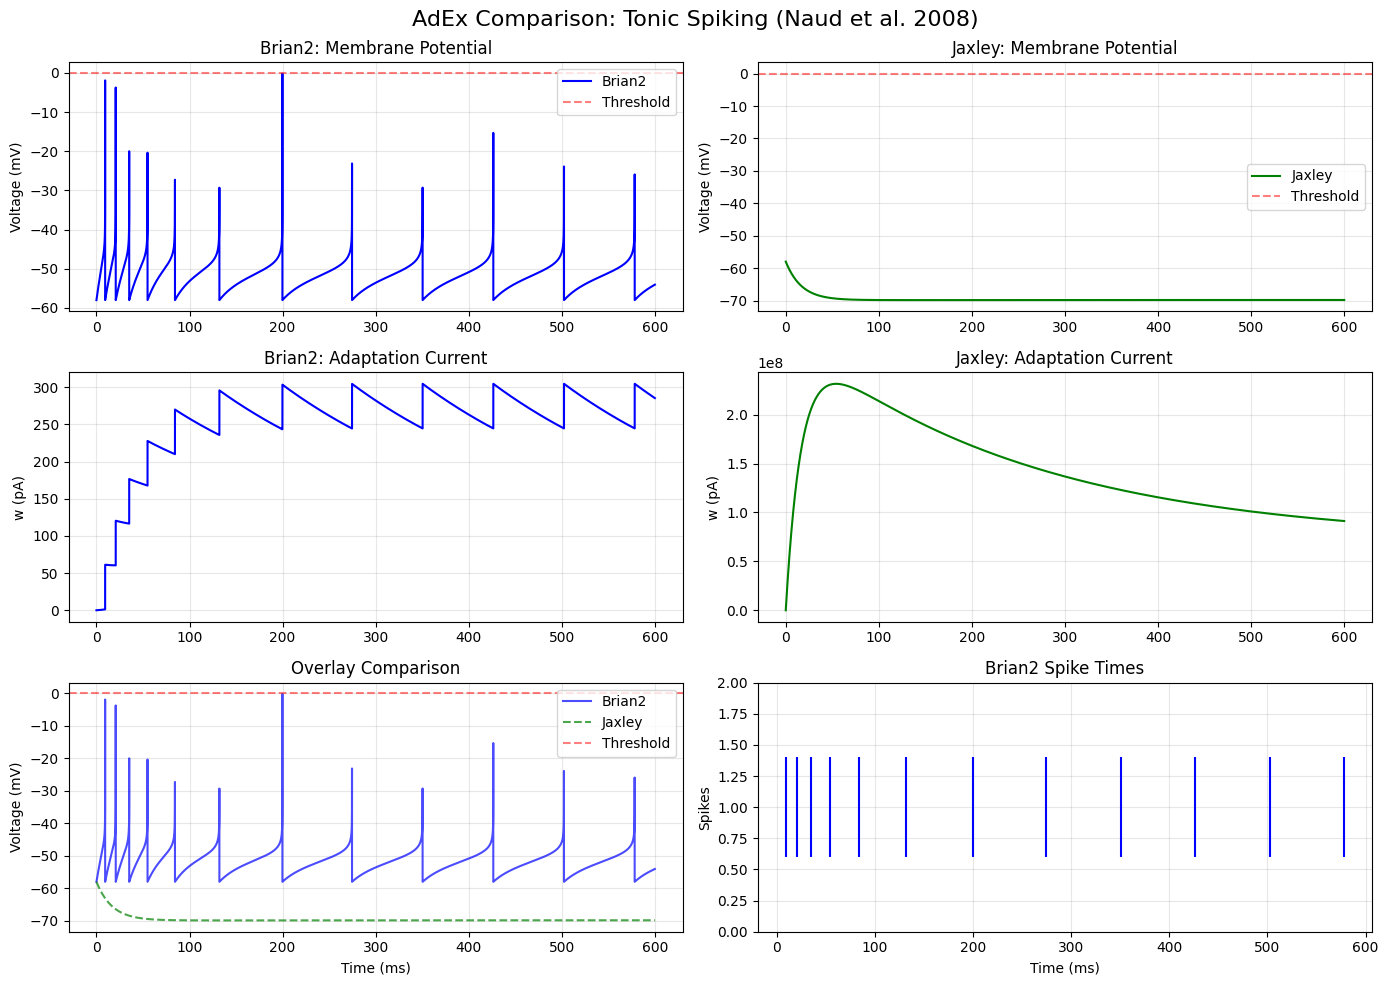

In [63]:

fig = plot_comparison(
    (t_brian, v_brian, w_brian, spikes_brian),
    (t_jaxley, v_jaxley, w_jaxley),
    NAUD_PARAMETERS['tonic'],
    title="AdEx Comparison: Tonic Spiking (Naud et al. 2008)"
)

plt.savefig('adex_comparison_tonic.png', dpi=150, bbox_inches='tight')
